In [1]:
import random

from finrl.meta.env_portfolio_allocation import env_portfolio

import pandas as pd
import numpy as np
import gym
from typing import Callable, Tuple
from collections import defaultdict
from tqdm import trange


In [2]:
def generate_episode(env: gym.Env, policy: Callable, es: bool = False):
    """A function to generate one episode and collect the sequence of (s, a, r) tuples

    This function will be useful for implementing the MC methods

    Args:
        env (gym.Env): a Gym API compatible environment
        policy (Callable): A function that represents the policy.
        es (bool): Whether to use exploring starts or not
    """
    episode = []
    state = env.reset()
    while True:
        if es and len(episode) == 0:
            action = env.action_space.sample()
        else:
            action = policy(state)

        next_state, reward, done, _ = env.step(action)
        episode.append((state, action, reward))
        if done:
            break
        state = next_state

    return episode


In [3]:
############STUFF GRABBED FROM FINRL TUTORIAL
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
import datetime

from finrl import config
from finrl import config_tickers
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from environments.portfolio_without_softmax import StockPortfolioEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline, convert_daily_return_to_pyfolio_ts
from finrl.meta.data_processor import DataProcessor
from finrl.meta.data_processors.processor_yahoofinance import YahooFinanceProcessor
import sys

## 2.4. Create Folders
import os

if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

print(config_tickers.DOW_30_TICKER)
#dp = YahooFinanceProcessor()
#df = dp.download_data

df = YahooDownloader(start_date='2008-01-01',
                     end_date='2021-10-31',
                     ticker_list=config_tickers.DOW_30_TICKER).fetch_data()

df.head()
df.shape


C:\Users\wacho\Programming\RL_Finance\venv\lib\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'CRM', 'VZ', 'V', 'WBA', 'WMT', 'DIS', 'DOW']
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%******

(101615, 8)

In [4]:
fe = FeatureEngineer(
    use_technical_indicator=True,
    use_turbulence=False,
    user_defined_feature=False)

df = fe.preprocess_data(df)
df.shape
df.head()

Successfully added technical indicators


,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma
0,2008-01-02,7.116786,7.152143,6.876786,5.898640,1079178800,AAPL,2,0.0,5.903858,5.896147,100.0,-66.666667,100.0,5.898640,5.898640
3483,2008-01-02,46.599998,47.040001,46.259998,33.761414,7934400,AMGN,2,0.0,5.903858,5.896147,100.0,-66.666667,100.0,33.761414,33.761414
6966,2008-01-02,52.090000,52.320000,50.790001,39.588009,8053700,AXP,2,0.0,5.903858,5.896147,100.0,-66.666667,100.0,39.588009,39.588009
10449,2008-01-02,87.570000,87.839996,86.000000,63.481621,4303000,BA,2,0.0,5.903858,5.896147,100.0,-66.666667,100.0,63.481621,63.481621
13932,2008-01-02,72.559998,72.669998,70.050003,45.605473,6337800,CAT,2,0.0,5.903858,5.896147,100.0,-66.666667,100.0,45.605473,45.605473


In [5]:
df.tail()

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma
83591,2021-10-29,162.130005,162.440002,160.660004,153.936371,1314100,TRV,4,1.424914,156.635663,144.752571,55.691930,130.838078,19.622993,149.630909,150.155365
87074,2021-10-29,454.410004,461.390015,453.059998,447.971069,2497800,UNH,4,12.812441,459.914496,366.732086,67.009729,145.348175,52.064871,406.440820,405.562355
90557,2021-10-29,52.500000,53.049999,52.410000,46.802307,17763200,VZ,4,-0.170569,48.086329,45.189773,46.685003,-39.966389,12.569826,46.875141,47.474614
94040,2021-10-29,46.860001,47.279999,46.770000,41.523602,4999000,WBA,4,-0.169816,44.202653,40.524218,45.913448,-97.394966,0.268701,42.391107,42.889372
97523,2021-10-29,147.910004,150.100006,147.559998,144.852386,7340900,WMT,4,1.795638,147.887254,129.205271,59.710625,130.750096,35.423702,138.057024,140.642314


In [6]:

## Add covariance matrix as states
# add covariance matrix as states
df = df.sort_values(['date', 'tic'], ignore_index=True)
df.index = df.date.factorize()[0]

cov_list = []
return_list = []

# look back is one year
lookback = 252
for i in range(lookback, len(df.index.unique())):
    data_lookback = df.loc[i - lookback:i, :]
    price_lookback = data_lookback.pivot_table(index='date', columns='tic', values='close')
    return_lookback = price_lookback.pct_change().dropna()
    return_list.append(return_lookback)

    covs = return_lookback.cov().values
    cov_list.append(covs)

df_cov = pd.DataFrame({'date': df.date.unique()[lookback:], 'cov_list': cov_list, 'return_list': return_list})
df = df.merge(df_cov, on='date')
df = df.sort_values(['date', 'tic']).reset_index(drop=True)

df.shape
df.head()


,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,cov_list,return_list
0,2008-12-31,3.070357,3.133571,3.047857,2.583910,607541200,AAPL,2,-0.082603,3.093652,2.454292,42.254782,-80.462462,16.129793,2.749560,2.861671,"[[0.0013489695222684568, 0.0004284131485040392...",tic AAPL AMGN AXP ...
1,2008-12-31,57.110001,58.220001,57.060001,41.839508,6287200,AMGN,2,0.156757,42.707033,40.853193,51.060590,51.523112,10.432018,41.058033,40.603776,"[[0.0013489695222684568, 0.0004284131485040392...",tic AAPL AMGN AXP ...
2,2008-12-31,17.969999,18.750000,17.910000,14.580747,9625600,AXP,2,-0.935583,18.646871,12.660475,42.554847,-75.437724,25.776759,15.744066,17.616375,"[[0.0013489695222684568, 0.0004284131485040392...",tic AAPL AMGN AXP ...
3,2008-12-31,41.590000,43.049999,41.500000,32.005894,5443100,BA,2,-0.279799,32.174385,28.867830,47.440246,156.994851,5.366299,30.327212,32.389915,"[[0.0013489695222684568, 0.0004284131485040392...",tic AAPL AMGN AXP ...
4,2008-12-31,43.700001,45.099998,43.700001,29.608664,6277400,CAT,2,0.655612,30.348088,25.455650,51.205321,98.374227,26.331746,26.689551,26.423592,"[[0.0013489695222684568, 0.0004284131485040392...",tic AAPL AMGN AXP ...


In [7]:
## Training data split: 2009-01-01 to 2020-07-01
train = data_split(df, '2009-01-01', '2020-07-01')
trade = data_split(df, '2020-07-01', '2021-10-31')
train.head()

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,cov_list,return_list
0,2009-01-02,3.067143,3.251429,3.041429,2.747390,746015200,AAPL,4,-0.070153,3.080129,2.452222,45.440189,-32.212925,2.140064,2.750408,2.862473,"[[0.0013661510434247453, 0.0004339387565938778...",tic AAPL AMGN AXP ...
0,2009-01-02,58.590000,59.080002,57.750000,42.737892,6547900,AMGN,4,0.232162,42.852626,40.817723,52.756856,92.827915,0.814217,41.122031,40.691922,"[[0.0013661510434247453, 0.0004339387565938778...",tic AAPL AMGN AXP ...
0,2009-01-02,18.570000,19.520000,18.400000,15.193848,10955700,AXP,4,-0.832050,18.463255,12.644439,43.957557,-42.853083,16.335101,15.742756,17.499520,"[[0.0013661510434247453, 0.0004339387565938778...",tic AAPL AMGN AXP ...
0,2009-01-02,42.799999,45.560001,42.779999,33.941093,7010200,BA,4,-0.002008,32.948627,28.452125,50.822033,272.812747,20.494464,30.469477,32.344131,"[[0.0013661510434247453, 0.0004339387565938778...",tic AAPL AMGN AXP ...
0,2009-01-02,44.910000,46.980000,44.709999,31.093405,7117200,CAT,4,0.833184,30.850189,25.434764,53.661257,129.524756,34.637448,26.926403,26.424174,"[[0.0013661510434247453, 0.0004339387565938778...",tic AAPL AMGN AXP ...


In [8]:
stock_dimension = len(train.tic.unique())
state_space = stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

env_kwargs = {
    "hmax": 100, 
    "initial_amount": 1000000, 
    "transaction_cost_pct": 0.001, 
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": config.INDICATORS, 
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4
    
}

e_train_gym_random = StockPortfolioEnv(df = train, **env_kwargs)


Stock Dimension: 28, State Space: 28


In [9]:
import random
def random_agent(env: StockPortfolioEnv):
    env.reset()
    terminal = False
    while not terminal:
        action = [0] * len(env.action_space.sample())
        action[random.randint(0,  len(env.action_space.sample()) - 1)] = 1
        state, reward, terminal, _, _ = env.step(action)
    return env

In [10]:
env_rand_post_training = random_agent(e_train_gym_random)

begin_total_asset:1000000
end_total_asset:4764465.253433425
Sharpe:  0.6610817931925641


In [11]:
from agents.single_stock_tabular import sarsa_single_stock

In [12]:
end_of_training_assets = []
end_of_trading_assets = []
episodes_for_training = list(range(1,51, 5))
for e in episodes_for_training:
    # todo, Need to test performance on 
    e_train_gym_single_stock_sarsa = StockPortfolioEnv(df = train, **env_kwargs)
    _, _, Q = sarsa_single_stock(e_train_gym_single_stock_sarsa, num_episodes=e, gamma=0.99, epsilon=0.1, step_size=0.5, stock=0)
    end_of_training_assets.append(e_train_gym_single_stock_sarsa.asset_memory)
    e_train_gym_single_stock_sarsa.reset()
    
    e_trade_gym_single_stock_sarsa = StockPortfolioEnv(df = trade, **env_kwargs)
    sarsa_single_stock(e_trade_gym_single_stock_sarsa, num_episodes=1, gamma=0.99, epsilon=0.1, step_size=0.5, stock=0, q=Q)
    end_of_trading_assets.append(e_trade_gym_single_stock_sarsa.asset_memory)
    e_trade_gym_single_stock_sarsa.reset()
    
    

begin_total_asset:1000000
end_total_asset:4324445.768363676
Sharpe:  0.8490098202203581


begin_total_asset:1000000
end_total_asset:1071847.3852360726
Sharpe:  0.3871164811689781


Episode:  17%|█▋        | 1/6 [00:05<00:27,  5.54s/it]

begin_total_asset:1000000
end_total_asset:4369549.498995927
Sharpe:  0.9320145607100305


Episode:  33%|███▎      | 2/6 [00:10<00:21,  5.49s/it]

begin_total_asset:1000000
end_total_asset:4058911.3648669035
Sharpe:  0.865058011151988


Episode:  50%|█████     | 3/6 [00:16<00:16,  5.48s/it]

begin_total_asset:1000000
end_total_asset:5649461.659741317
Sharpe:  1.0413083058953365


Episode:  67%|██████▋   | 4/6 [00:22<00:11,  5.60s/it]

begin_total_asset:1000000
end_total_asset:6812703.21586243
Sharpe:  1.1538505296282067


Episode:  83%|████████▎ | 5/6 [00:27<00:05,  5.60s/it]

begin_total_asset:1000000
end_total_asset:6471046.547181974
Sharpe:  1.0652794916483002


begin_total_asset:1000000
end_total_asset:9385080.514181664
Sharpe:  1.1164962940859529


begin_total_asset:1000000
end_total_asset:1350491.6893294929
Sharpe:  1.2670182871791795


Episode:   9%|▉         | 1/11 [00:05<00:55,  5.58s/it]

begin_total_asset:1000000
end_total_asset:5927223.30756525
Sharpe:  1.0709268476071874


Episode:  18%|█▊        | 2/11 [00:11<00:49,  5.54s/it]

begin_total_asset:1000000
end_total_asset:7065185.522224199
Sharpe:  1.16062783971647


Episode:  27%|██▋       | 3/11 [00:16<00:44,  5.51s/it]

begin_total_asset:1000000
end_total_asset:8215197.131000419
Sharpe:  1.1702663328310752


Episode:  36%|███▋      | 4/11 [00:22<00:38,  5.54s/it]

begin_total_asset:1000000
end_total_asset:6830982.2098111315
Sharpe:  1.0192116116760412


Episode:  45%|████▌     | 5/11 [00:27<00:33,  5.54s/it]

begin_total_asset:1000000
end_total_asset:8891917.961095734
Sharpe:  1.2034289585866178


Episode:  55%|█████▍    | 6/11 [00:33<00:28,  5.77s/it]

begin_total_asset:1000000
end_total_asset:8221247.798231966
Sharpe:  1.2239180184810647


Episode:  64%|██████▎   | 7/11 [00:39<00:23,  5.79s/it]

begin_total_asset:1000000
end_total_asset:3546726.2114233943
Sharpe:  0.7611154706940157


Episode:  73%|███████▎  | 8/11 [00:46<00:18,  6.02s/it]

begin_total_asset:1000000
end_total_asset:4390542.337238162
Sharpe:  0.9307990287625975


Episode:  82%|████████▏ | 9/11 [00:51<00:11,  5.93s/it]

begin_total_asset:1000000
end_total_asset:4255805.259058648
Sharpe:  0.9593677536877073


Episode:  91%|█████████ | 10/11 [00:57<00:05,  5.82s/it]

begin_total_asset:1000000
end_total_asset:3624086.081342402
Sharpe:  0.8892555658476939


begin_total_asset:1000000
end_total_asset:6611194.953309169
Sharpe:  1.0901683930961559


begin_total_asset:1000000
end_total_asset:1283070.5460020853
Sharpe:  1.3130133351817301


Episode:   6%|▋         | 1/16 [00:05<01:22,  5.47s/it]

begin_total_asset:1000000
end_total_asset:3916756.6424648482
Sharpe:  0.8189360434918763


Episode:  12%|█▎        | 2/16 [00:11<01:21,  5.82s/it]

begin_total_asset:1000000
end_total_asset:3470109.484136841
Sharpe:  0.7944586282254702


Episode:  19%|█▉        | 3/16 [00:17<01:16,  5.87s/it]

begin_total_asset:1000000
end_total_asset:3220746.7156396685
Sharpe:  0.8001759196570667


Episode:  25%|██▌       | 4/16 [00:23<01:10,  5.84s/it]

begin_total_asset:1000000
end_total_asset:3904505.0500868075
Sharpe:  0.9338412299913302


Episode:  31%|███▏      | 5/16 [00:28<01:03,  5.79s/it]

begin_total_asset:1000000
end_total_asset:4076778.297736179
Sharpe:  0.882993957851651


Episode:  38%|███▊      | 6/16 [00:34<00:57,  5.73s/it]

begin_total_asset:1000000
end_total_asset:4529116.278636064
Sharpe:  0.9476164980858527


Episode:  44%|████▍     | 7/16 [00:40<00:51,  5.68s/it]

begin_total_asset:1000000
end_total_asset:5629235.735935734
Sharpe:  1.0152208576289914


Episode:  50%|█████     | 8/16 [00:45<00:45,  5.63s/it]

begin_total_asset:1000000
end_total_asset:6440576.361973233
Sharpe:  1.0954504035199322


Episode:  56%|█████▋    | 9/16 [00:51<00:39,  5.60s/it]

begin_total_asset:1000000
end_total_asset:3709005.1823652526
Sharpe:  0.8743280206247221


Episode:  62%|██████▎   | 10/16 [00:56<00:33,  5.59s/it]

begin_total_asset:1000000
end_total_asset:3274686.6271350547
Sharpe:  0.8089432863201819


Episode:  69%|██████▉   | 11/16 [01:02<00:27,  5.56s/it]

begin_total_asset:1000000
end_total_asset:3091873.5847407156
Sharpe:  0.7441070901568917


Episode:  75%|███████▌  | 12/16 [01:07<00:22,  5.58s/it]

begin_total_asset:1000000
end_total_asset:9366720.88978548
Sharpe:  1.2982772079583478


Episode:  81%|████████▏ | 13/16 [01:13<00:16,  5.56s/it]

begin_total_asset:1000000
end_total_asset:4626274.8341861535
Sharpe:  0.9644727515331938


Episode:  88%|████████▊ | 14/16 [01:19<00:11,  5.58s/it]

begin_total_asset:1000000
end_total_asset:4996200.439519455
Sharpe:  1.0625047598907906


Episode:  94%|█████████▍| 15/16 [01:24<00:05,  5.63s/it]

begin_total_asset:1000000
end_total_asset:7166041.369616438
Sharpe:  1.1184255301673909


begin_total_asset:1000000
end_total_asset:3871974.0072147693
Sharpe:  0.8604592538935367


begin_total_asset:1000000
end_total_asset:1073225.964914004
Sharpe:  0.5259993919735009


Episode:   5%|▍         | 1/21 [00:05<01:49,  5.49s/it]

begin_total_asset:1000000
end_total_asset:4915690.75606735
Sharpe:  0.9319119797086289


Episode:  10%|▉         | 2/21 [00:11<01:45,  5.54s/it]

begin_total_asset:1000000
end_total_asset:8508212.812514674
Sharpe:  1.1403026008778618


Episode:  14%|█▍        | 3/21 [00:16<01:40,  5.57s/it]

begin_total_asset:1000000
end_total_asset:9329061.140305476
Sharpe:  1.2109935939029481


Episode:  19%|█▉        | 4/21 [00:22<01:35,  5.62s/it]

begin_total_asset:1000000
end_total_asset:7080169.880523598
Sharpe:  1.0053090065463113


Episode:  24%|██▍       | 5/21 [00:28<01:30,  5.64s/it]

begin_total_asset:1000000
end_total_asset:7918886.211241293
Sharpe:  1.1482124559943325


Episode:  29%|██▊       | 6/21 [00:33<01:24,  5.63s/it]

begin_total_asset:1000000
end_total_asset:4545116.598757852
Sharpe:  0.8627049348334032


Episode:  33%|███▎      | 7/21 [00:39<01:20,  5.72s/it]

begin_total_asset:1000000
end_total_asset:7811633.586824133
Sharpe:  1.3068673059450033


Episode:  38%|███▊      | 8/21 [00:45<01:14,  5.73s/it]

begin_total_asset:1000000
end_total_asset:5877289.335370155
Sharpe:  1.0399003679473993


Episode:  43%|████▎     | 9/21 [00:50<01:08,  5.67s/it]

begin_total_asset:1000000
end_total_asset:6861118.425760077
Sharpe:  1.093537705485784


Episode:  48%|████▊     | 10/21 [00:56<01:02,  5.69s/it]

begin_total_asset:1000000
end_total_asset:5143073.299088496
Sharpe:  0.9707556688543086


Episode:  52%|█████▏    | 11/21 [01:02<00:56,  5.69s/it]

begin_total_asset:1000000
end_total_asset:9003404.356773233
Sharpe:  1.2806949961368548


Episode:  57%|█████▋    | 12/21 [01:08<00:53,  5.95s/it]

begin_total_asset:1000000
end_total_asset:7767345.945177387
Sharpe:  1.1265208507949642


Episode:  62%|██████▏   | 13/21 [01:14<00:46,  5.85s/it]

begin_total_asset:1000000
end_total_asset:6884633.8798262905
Sharpe:  1.1625701977745075


Episode:  67%|██████▋   | 14/21 [01:19<00:40,  5.72s/it]

begin_total_asset:1000000
end_total_asset:6851338.097372073
Sharpe:  1.1779446233897497


Episode:  71%|███████▏  | 15/21 [01:25<00:33,  5.64s/it]

begin_total_asset:1000000
end_total_asset:4431626.905822232
Sharpe:  1.0511293501226338


Episode:  76%|███████▌  | 16/21 [01:30<00:27,  5.59s/it]

begin_total_asset:1000000
end_total_asset:5526541.125998448
Sharpe:  1.0707419354090595


Episode:  81%|████████  | 17/21 [01:36<00:22,  5.55s/it]

begin_total_asset:1000000
end_total_asset:5633846.372286742
Sharpe:  1.047646931625585


Episode:  86%|████████▌ | 18/21 [01:41<00:16,  5.55s/it]

begin_total_asset:1000000
end_total_asset:3307625.948516842
Sharpe:  0.8696410759715548


Episode:  90%|█████████ | 19/21 [01:47<00:11,  5.56s/it]

begin_total_asset:1000000
end_total_asset:5086760.163879063
Sharpe:  1.128767611545161


Episode:  95%|█████████▌| 20/21 [01:52<00:05,  5.54s/it]

begin_total_asset:1000000
end_total_asset:3870245.773731292
Sharpe:  0.8960749070082095


begin_total_asset:1000000
end_total_asset:6462002.039407039
Sharpe:  1.2209772800714431


begin_total_asset:1000000
end_total_asset:1061436.8850859306
Sharpe:  0.39283957898179034


Episode:   4%|▍         | 1/26 [00:05<02:18,  5.53s/it]

begin_total_asset:1000000
end_total_asset:5946231.095603873
Sharpe:  1.008264796654918


Episode:   8%|▊         | 2/26 [00:11<02:13,  5.55s/it]

begin_total_asset:1000000
end_total_asset:7215777.0778423315
Sharpe:  1.0948873596723179


Episode:  12%|█▏        | 3/26 [00:16<02:07,  5.53s/it]

begin_total_asset:1000000
end_total_asset:7562178.011331471
Sharpe:  1.1765570088473376


Episode:  15%|█▌        | 4/26 [00:22<02:01,  5.54s/it]

begin_total_asset:1000000
end_total_asset:8359981.368602811
Sharpe:  1.3018250231023396


Episode:  19%|█▉        | 5/26 [00:27<01:56,  5.54s/it]

begin_total_asset:1000000
end_total_asset:7430780.05153502
Sharpe:  1.1858559526328802


Episode:  23%|██▎       | 6/26 [00:33<01:50,  5.51s/it]

begin_total_asset:1000000
end_total_asset:5437248.434358636
Sharpe:  1.032532051889091


Episode:  27%|██▋       | 7/26 [00:38<01:44,  5.50s/it]

begin_total_asset:1000000
end_total_asset:4357649.504718402
Sharpe:  0.8693959764975856


Episode:  31%|███       | 8/26 [00:44<01:38,  5.49s/it]

begin_total_asset:1000000
end_total_asset:6367276.939121817
Sharpe:  1.0574942923284167


Episode:  35%|███▍      | 9/26 [00:49<01:33,  5.52s/it]

begin_total_asset:1000000
end_total_asset:4843720.491472701
Sharpe:  0.9000077389086293


Episode:  38%|███▊      | 10/26 [00:55<01:28,  5.50s/it]

begin_total_asset:1000000
end_total_asset:4480251.711574128
Sharpe:  0.9140127512842099


Episode:  42%|████▏     | 11/26 [01:00<01:22,  5.49s/it]

begin_total_asset:1000000
end_total_asset:6586138.5268371785
Sharpe:  0.9911216155456544


Episode:  46%|████▌     | 12/26 [01:06<01:16,  5.48s/it]

begin_total_asset:1000000
end_total_asset:6787833.609534626
Sharpe:  1.0661579241218717


Episode:  50%|█████     | 13/26 [01:11<01:11,  5.48s/it]

begin_total_asset:1000000
end_total_asset:4624996.060635702
Sharpe:  0.957622317691425


Episode:  54%|█████▍    | 14/26 [01:17<01:05,  5.47s/it]

begin_total_asset:1000000
end_total_asset:7441703.477878669
Sharpe:  1.2208589278016984


Episode:  58%|█████▊    | 15/26 [01:22<01:00,  5.48s/it]

begin_total_asset:1000000
end_total_asset:9198291.590619411
Sharpe:  1.2140857090732473


Episode:  62%|██████▏   | 16/26 [01:27<00:54,  5.48s/it]

begin_total_asset:1000000
end_total_asset:4153937.815732047
Sharpe:  0.8332728644412533


Episode:  65%|██████▌   | 17/26 [01:33<00:49,  5.47s/it]

begin_total_asset:1000000
end_total_asset:8473506.871142585
Sharpe:  1.2694022581445286


Episode:  69%|██████▉   | 18/26 [01:39<00:44,  5.52s/it]

begin_total_asset:1000000
end_total_asset:5550482.034401149
Sharpe:  0.9449616443835497


Episode:  73%|███████▎  | 19/26 [01:44<00:38,  5.51s/it]

begin_total_asset:1000000
end_total_asset:5951353.475150333
Sharpe:  1.0423058765944921


Episode:  77%|███████▋  | 20/26 [01:50<00:33,  5.50s/it]

begin_total_asset:1000000
end_total_asset:4154476.8556353357
Sharpe:  0.8221413620509885


Episode:  81%|████████  | 21/26 [01:55<00:27,  5.50s/it]

begin_total_asset:1000000
end_total_asset:6866008.642618048
Sharpe:  1.2442411118027163


Episode:  85%|████████▍ | 22/26 [02:01<00:22,  5.57s/it]

begin_total_asset:1000000
end_total_asset:6174446.418273313
Sharpe:  1.1665676350235195


Episode:  88%|████████▊ | 23/26 [02:06<00:16,  5.58s/it]

begin_total_asset:1000000
end_total_asset:3383499.362897279
Sharpe:  0.9428369012912964


Episode:  92%|█████████▏| 24/26 [02:13<00:11,  5.83s/it]

begin_total_asset:1000000
end_total_asset:3557884.1734544267
Sharpe:  0.8414651318988581


Episode:  96%|█████████▌| 25/26 [02:19<00:05,  5.83s/it]

begin_total_asset:1000000
end_total_asset:7235808.864035815
Sharpe:  1.1690291986703445


begin_total_asset:1000000
end_total_asset:4151192.6982533946
Sharpe:  0.9358343552612026


begin_total_asset:1000000
end_total_asset:1182660.5822511069
Sharpe:  0.8465166654276094


Episode:   3%|▎         | 1/31 [00:05<02:51,  5.72s/it]

begin_total_asset:1000000
end_total_asset:4729879.211041332
Sharpe:  0.8620221741654167


Episode:   6%|▋         | 2/31 [00:11<02:46,  5.76s/it]

begin_total_asset:1000000
end_total_asset:3760189.833798382
Sharpe:  0.7185930395621658


Episode:  10%|▉         | 3/31 [00:17<02:41,  5.75s/it]

begin_total_asset:1000000
end_total_asset:3365281.33306878
Sharpe:  0.6867073201589137


Episode:  13%|█▎        | 4/31 [00:23<02:37,  5.82s/it]

begin_total_asset:1000000
end_total_asset:4527103.5700123
Sharpe:  0.8414905238827826


Episode:  16%|█▌        | 5/31 [00:29<02:31,  5.83s/it]

begin_total_asset:1000000
end_total_asset:3614200.8923135702
Sharpe:  0.7727209163382726


Episode:  19%|█▉        | 6/31 [00:34<02:23,  5.75s/it]

begin_total_asset:1000000
end_total_asset:3417045.309730664
Sharpe:  0.7090413154697816


Episode:  23%|██▎       | 7/31 [00:40<02:17,  5.74s/it]

begin_total_asset:1000000
end_total_asset:5244424.7867820915
Sharpe:  0.8966098693362666


Episode:  26%|██▌       | 8/31 [00:45<02:10,  5.69s/it]

begin_total_asset:1000000
end_total_asset:3243872.1126382933
Sharpe:  0.7280515385963595


Episode:  29%|██▉       | 9/31 [00:51<02:05,  5.71s/it]

begin_total_asset:1000000
end_total_asset:3127050.8163915407
Sharpe:  0.7195981750164303


Episode:  32%|███▏      | 10/31 [00:57<01:59,  5.69s/it]

begin_total_asset:1000000
end_total_asset:4697435.745014871
Sharpe:  0.8765525667741206


Episode:  35%|███▌      | 11/31 [01:03<01:54,  5.70s/it]

begin_total_asset:1000000
end_total_asset:4312472.843720538
Sharpe:  0.8163810698283818


Episode:  39%|███▊      | 12/31 [01:08<01:48,  5.71s/it]

begin_total_asset:1000000
end_total_asset:4957861.8619601345
Sharpe:  0.9413182801768786


Episode:  42%|████▏     | 13/31 [01:14<01:41,  5.65s/it]

begin_total_asset:1000000
end_total_asset:5261763.248420338
Sharpe:  0.9935860980913074


Episode:  45%|████▌     | 14/31 [01:19<01:34,  5.58s/it]

begin_total_asset:1000000
end_total_asset:3931928.1523384163
Sharpe:  0.739223688341462


Episode:  48%|████▊     | 15/31 [01:25<01:29,  5.58s/it]

begin_total_asset:1000000
end_total_asset:5642703.919762565
Sharpe:  1.0211952542297695


Episode:  52%|█████▏    | 16/31 [01:31<01:26,  5.75s/it]

begin_total_asset:1000000
end_total_asset:2813337.8683236525
Sharpe:  0.6768112035294978


Episode:  55%|█████▍    | 17/31 [01:37<01:20,  5.74s/it]

begin_total_asset:1000000
end_total_asset:3207815.0617397795
Sharpe:  0.7615109239122594


Episode:  58%|█████▊    | 18/31 [01:42<01:14,  5.72s/it]

begin_total_asset:1000000
end_total_asset:3641585.7802191987
Sharpe:  0.7955901144821927


Episode:  61%|██████▏   | 19/31 [01:48<01:08,  5.67s/it]

begin_total_asset:1000000
end_total_asset:4438184.375888099
Sharpe:  0.9728306270768139


Episode:  65%|██████▍   | 20/31 [01:53<01:02,  5.65s/it]

begin_total_asset:1000000
end_total_asset:6372358.04068609
Sharpe:  1.168497991070086


Episode:  68%|██████▊   | 21/31 [01:59<00:56,  5.65s/it]

begin_total_asset:1000000
end_total_asset:4883909.1229415275
Sharpe:  1.0608378091986836


Episode:  71%|███████   | 22/31 [02:05<00:50,  5.62s/it]

begin_total_asset:1000000
end_total_asset:5585706.848472507
Sharpe:  1.0749116020308715


Episode:  74%|███████▍  | 23/31 [02:10<00:44,  5.59s/it]

begin_total_asset:1000000
end_total_asset:4428069.2231528275
Sharpe:  0.9926413402121201


Episode:  77%|███████▋  | 24/31 [02:16<00:39,  5.61s/it]

begin_total_asset:1000000
end_total_asset:5307320.320736301
Sharpe:  0.9924087162280735


Episode:  81%|████████  | 25/31 [02:22<00:33,  5.62s/it]

begin_total_asset:1000000
end_total_asset:6527187.872335032
Sharpe:  1.3053441134846135


Episode:  84%|████████▍ | 26/31 [02:27<00:28,  5.61s/it]

begin_total_asset:1000000
end_total_asset:8804637.485872459
Sharpe:  1.3871458244353656


Episode:  87%|████████▋ | 27/31 [02:33<00:22,  5.64s/it]

begin_total_asset:1000000
end_total_asset:6505738.833527828
Sharpe:  1.0530048686966493


Episode:  90%|█████████ | 28/31 [02:38<00:16,  5.63s/it]

begin_total_asset:1000000
end_total_asset:5714753.261500647
Sharpe:  1.0646971417189044


Episode:  94%|█████████▎| 29/31 [02:44<00:11,  5.67s/it]

begin_total_asset:1000000
end_total_asset:7667183.405828504
Sharpe:  1.1109404380168537


Episode:  97%|█████████▋| 30/31 [02:50<00:05,  5.66s/it]

begin_total_asset:1000000
end_total_asset:5085338.389438984
Sharpe:  1.0531850933617664


begin_total_asset:1000000
end_total_asset:6143506.591250036
Sharpe:  1.0862539145895678


begin_total_asset:1000000
end_total_asset:1289572.8822724635
Sharpe:  1.585232877515345


Episode:   3%|▎         | 1/36 [00:05<03:16,  5.62s/it]

begin_total_asset:1000000
end_total_asset:5848264.452937525
Sharpe:  1.0191179030122386


Episode:   6%|▌         | 2/36 [00:11<03:10,  5.61s/it]

begin_total_asset:1000000
end_total_asset:7880704.153600408
Sharpe:  1.1652316676160415


Episode:   8%|▊         | 3/36 [00:16<03:05,  5.62s/it]

begin_total_asset:1000000
end_total_asset:8814230.845709337
Sharpe:  1.1979649455563393


Episode:  11%|█         | 4/36 [00:22<03:02,  5.69s/it]

begin_total_asset:1000000
end_total_asset:12937994.361478023
Sharpe:  1.3955496557641476


Episode:  14%|█▍        | 5/36 [00:28<02:55,  5.66s/it]

begin_total_asset:1000000
end_total_asset:8383767.249489833
Sharpe:  1.3270154570232575


Episode:  17%|█▋        | 6/36 [00:33<02:49,  5.65s/it]

begin_total_asset:1000000
end_total_asset:5370949.337674063
Sharpe:  1.1004243153145095


Episode:  19%|█▉        | 7/36 [00:39<02:43,  5.65s/it]

begin_total_asset:1000000
end_total_asset:4775464.846949575
Sharpe:  0.9811136443014923


Episode:  22%|██▏       | 8/36 [00:45<02:37,  5.64s/it]

begin_total_asset:1000000
end_total_asset:7694731.183101724
Sharpe:  1.0937698895878534


Episode:  25%|██▌       | 9/36 [00:50<02:33,  5.67s/it]

begin_total_asset:1000000
end_total_asset:5674305.320263938
Sharpe:  0.9829443594027859


Episode:  28%|██▊       | 10/36 [00:56<02:27,  5.66s/it]

begin_total_asset:1000000
end_total_asset:5568117.579145899
Sharpe:  1.0903208347695024


Episode:  31%|███       | 11/36 [01:02<02:22,  5.68s/it]

begin_total_asset:1000000
end_total_asset:5105993.366840014
Sharpe:  0.9962921494515378


Episode:  33%|███▎      | 12/36 [01:07<02:16,  5.68s/it]

begin_total_asset:1000000
end_total_asset:6042472.012644738
Sharpe:  1.0452276044946094


Episode:  36%|███▌      | 13/36 [01:13<02:11,  5.70s/it]

begin_total_asset:1000000
end_total_asset:8357451.386255331
Sharpe:  1.339400621085543


Episode:  39%|███▉      | 14/36 [01:19<02:05,  5.72s/it]

begin_total_asset:1000000
end_total_asset:5089292.914421516
Sharpe:  1.0232849337441252


Episode:  42%|████▏     | 15/36 [01:25<01:59,  5.70s/it]

begin_total_asset:1000000
end_total_asset:5732337.083053017
Sharpe:  1.0937200479425093


Episode:  44%|████▍     | 16/36 [01:30<01:53,  5.70s/it]

begin_total_asset:1000000
end_total_asset:8964976.128950559
Sharpe:  1.3111846681318848


Episode:  47%|████▋     | 17/36 [01:36<01:47,  5.68s/it]

begin_total_asset:1000000
end_total_asset:6142643.718569546
Sharpe:  1.0605506921942367


Episode:  50%|█████     | 18/36 [01:42<01:41,  5.66s/it]

begin_total_asset:1000000
end_total_asset:11600195.014608871
Sharpe:  1.3901721870787143


Episode:  53%|█████▎    | 19/36 [01:47<01:36,  5.66s/it]

begin_total_asset:1000000
end_total_asset:8196240.888481279
Sharpe:  1.1989347111874014


Episode:  56%|█████▌    | 20/36 [01:53<01:31,  5.69s/it]

begin_total_asset:1000000
end_total_asset:10880256.05857789
Sharpe:  1.2258047218270707


Episode:  58%|█████▊    | 21/36 [01:59<01:25,  5.68s/it]

begin_total_asset:1000000
end_total_asset:10070311.320462134
Sharpe:  1.2310354088438336


Episode:  61%|██████    | 22/36 [02:05<01:21,  5.85s/it]

begin_total_asset:1000000
end_total_asset:9195656.443036389
Sharpe:  1.2054251897357409


Episode:  64%|██████▍   | 23/36 [02:11<01:15,  5.81s/it]

begin_total_asset:1000000
end_total_asset:7910001.926386475
Sharpe:  1.151706984487438


Episode:  67%|██████▋   | 24/36 [02:17<01:10,  5.89s/it]

begin_total_asset:1000000
end_total_asset:10080131.162998317
Sharpe:  1.169276431561128


Episode:  69%|██████▉   | 25/36 [02:23<01:05,  5.97s/it]

begin_total_asset:1000000
end_total_asset:11254398.332041997
Sharpe:  1.3378553220711265


Episode:  72%|███████▏  | 26/36 [02:28<00:58,  5.87s/it]

begin_total_asset:1000000
end_total_asset:9375702.951307628
Sharpe:  1.1363355086040483


Episode:  75%|███████▌  | 27/36 [02:34<00:52,  5.81s/it]

begin_total_asset:1000000
end_total_asset:10082046.721833458
Sharpe:  1.2307957276685912


Episode:  78%|███████▊  | 28/36 [02:40<00:46,  5.78s/it]

begin_total_asset:1000000
end_total_asset:11467828.533586007
Sharpe:  1.1537313549454153


Episode:  81%|████████  | 29/36 [02:45<00:40,  5.73s/it]

begin_total_asset:1000000
end_total_asset:6757015.35365142
Sharpe:  1.0215804647471625


Episode:  83%|████████▎ | 30/36 [02:51<00:34,  5.72s/it]

begin_total_asset:1000000
end_total_asset:9697135.476627104
Sharpe:  1.2692141402926544


Episode:  86%|████████▌ | 31/36 [02:57<00:28,  5.77s/it]

begin_total_asset:1000000
end_total_asset:10321277.71972662
Sharpe:  1.2825705702913317


Episode:  89%|████████▉ | 32/36 [03:03<00:22,  5.73s/it]

begin_total_asset:1000000
end_total_asset:7009064.475998471
Sharpe:  0.9912280563182392


Episode:  92%|█████████▏| 33/36 [03:08<00:17,  5.73s/it]

begin_total_asset:1000000
end_total_asset:6121283.090939216
Sharpe:  1.0217738671249734


Episode:  94%|█████████▍| 34/36 [03:14<00:11,  5.70s/it]

begin_total_asset:1000000
end_total_asset:9267817.067409407
Sharpe:  1.1764968275231182


Episode:  97%|█████████▋| 35/36 [03:20<00:05,  5.91s/it]

begin_total_asset:1000000
end_total_asset:8630548.25095414
Sharpe:  1.2814989292443275


begin_total_asset:1000000
end_total_asset:6266608.596080248
Sharpe:  0.9997560810539562


begin_total_asset:1000000
end_total_asset:1423030.946406434
Sharpe:  1.319481657746267


Episode:   2%|▏         | 1/41 [00:05<03:52,  5.81s/it]

begin_total_asset:1000000
end_total_asset:6353590.964223358
Sharpe:  1.101609379569487


Episode:   5%|▍         | 2/41 [00:11<03:44,  5.75s/it]

begin_total_asset:1000000
end_total_asset:5682165.023113545
Sharpe:  1.0111093867839558


Episode:   7%|▋         | 3/41 [00:17<03:41,  5.82s/it]

begin_total_asset:1000000
end_total_asset:5363431.925668373
Sharpe:  0.931095273755772


Episode:  10%|▉         | 4/41 [00:23<03:34,  5.80s/it]

begin_total_asset:1000000
end_total_asset:9152865.759881819
Sharpe:  1.1496318015384108


Episode:  12%|█▏        | 5/41 [00:28<03:27,  5.75s/it]

begin_total_asset:1000000
end_total_asset:9341484.29827738
Sharpe:  1.1753725014906573


Episode:  15%|█▍        | 6/41 [00:34<03:19,  5.70s/it]

begin_total_asset:1000000
end_total_asset:10091705.437737476
Sharpe:  1.2917566502535374


Episode:  17%|█▋        | 7/41 [00:40<03:13,  5.68s/it]

begin_total_asset:1000000
end_total_asset:7856419.616514302
Sharpe:  1.0899899071021915


Episode:  20%|█▉        | 8/41 [00:45<03:06,  5.65s/it]

begin_total_asset:1000000
end_total_asset:7723657.5996916285
Sharpe:  1.23563891255112


Episode:  22%|██▏       | 9/41 [00:51<03:00,  5.64s/it]

begin_total_asset:1000000
end_total_asset:8341121.002711814
Sharpe:  1.1894791721764795


Episode:  24%|██▍       | 10/41 [00:56<02:54,  5.63s/it]

begin_total_asset:1000000
end_total_asset:5956402.605734033
Sharpe:  0.9285074896086093


Episode:  27%|██▋       | 11/41 [01:02<02:49,  5.65s/it]

begin_total_asset:1000000
end_total_asset:11275297.179822441
Sharpe:  1.33302145545075


Episode:  29%|██▉       | 12/41 [01:09<02:52,  5.93s/it]

begin_total_asset:1000000
end_total_asset:6062355.634197063
Sharpe:  1.0693868340480186


Episode:  32%|███▏      | 13/41 [01:15<02:48,  6.03s/it]

begin_total_asset:1000000
end_total_asset:10513151.672753934
Sharpe:  1.250649067296143


Episode:  34%|███▍      | 14/41 [01:20<02:38,  5.87s/it]

begin_total_asset:1000000
end_total_asset:10040265.024954285
Sharpe:  1.1950002670615463


Episode:  37%|███▋      | 15/41 [01:26<02:29,  5.76s/it]

begin_total_asset:1000000
end_total_asset:8616715.90513315
Sharpe:  1.2286264902591961


Episode:  39%|███▉      | 16/41 [01:32<02:22,  5.71s/it]

begin_total_asset:1000000
end_total_asset:6878183.31549439
Sharpe:  1.0570611967092132


Episode:  41%|████▏     | 17/41 [01:37<02:16,  5.69s/it]

begin_total_asset:1000000
end_total_asset:5927607.784297285
Sharpe:  1.0204181921533304


Episode:  44%|████▍     | 18/41 [01:43<02:11,  5.73s/it]

begin_total_asset:1000000
end_total_asset:7102577.057860319
Sharpe:  1.0908585945056257


Episode:  46%|████▋     | 19/41 [01:49<02:05,  5.73s/it]

begin_total_asset:1000000
end_total_asset:7209462.7485149745
Sharpe:  1.0022500833099186


Episode:  49%|████▉     | 20/41 [01:54<01:58,  5.66s/it]

begin_total_asset:1000000
end_total_asset:10764779.014261784
Sharpe:  1.1568632875888833


Episode:  51%|█████     | 21/41 [02:00<01:52,  5.62s/it]

begin_total_asset:1000000
end_total_asset:5428616.282245368
Sharpe:  0.9387383671678355


Episode:  54%|█████▎    | 22/41 [02:05<01:46,  5.62s/it]

begin_total_asset:1000000
end_total_asset:6166258.836719752
Sharpe:  1.090710845341234


Episode:  56%|█████▌    | 23/41 [02:11<01:40,  5.59s/it]

begin_total_asset:1000000
end_total_asset:12057393.521797212
Sharpe:  1.3390544022116602


Episode:  59%|█████▊    | 24/41 [02:16<01:35,  5.59s/it]

begin_total_asset:1000000
end_total_asset:10693766.10959879
Sharpe:  1.300328672770617


Episode:  61%|██████    | 25/41 [02:22<01:28,  5.56s/it]

begin_total_asset:1000000
end_total_asset:7005210.518215439
Sharpe:  1.2401956713774032


Episode:  63%|██████▎   | 26/41 [02:27<01:23,  5.54s/it]

begin_total_asset:1000000
end_total_asset:4095928.507474397
Sharpe:  0.8836447461879013


Episode:  66%|██████▌   | 27/41 [02:33<01:17,  5.55s/it]

begin_total_asset:1000000
end_total_asset:6595349.595018338
Sharpe:  0.9938562894011975


Episode:  68%|██████▊   | 28/41 [02:39<01:12,  5.54s/it]

begin_total_asset:1000000
end_total_asset:7030356.636388225
Sharpe:  1.0231609367822854


Episode:  71%|███████   | 29/41 [02:44<01:06,  5.55s/it]

begin_total_asset:1000000
end_total_asset:6120675.643423284
Sharpe:  1.0504764601046384


Episode:  73%|███████▎  | 30/41 [02:50<01:00,  5.54s/it]

begin_total_asset:1000000
end_total_asset:5730960.234882177
Sharpe:  1.0640827057776785


Episode:  76%|███████▌  | 31/41 [02:55<00:56,  5.61s/it]

begin_total_asset:1000000
end_total_asset:4109588.3702879176
Sharpe:  0.9176456732449164


Episode:  78%|███████▊  | 32/41 [03:02<00:51,  5.76s/it]

begin_total_asset:1000000
end_total_asset:6742594.63558415
Sharpe:  1.052655452816662


Episode:  80%|████████  | 33/41 [03:07<00:46,  5.80s/it]

begin_total_asset:1000000
end_total_asset:4134712.871402407
Sharpe:  0.8243733006849301


Episode:  83%|████████▎ | 34/41 [03:13<00:40,  5.81s/it]

begin_total_asset:1000000
end_total_asset:4814395.342106627
Sharpe:  0.9725043514160779


Episode:  85%|████████▌ | 35/41 [03:19<00:34,  5.77s/it]

begin_total_asset:1000000
end_total_asset:4791809.103499684
Sharpe:  1.0508555360231804


Episode:  88%|████████▊ | 36/41 [03:25<00:28,  5.72s/it]

begin_total_asset:1000000
end_total_asset:5787094.995964412
Sharpe:  0.9863384483967171


Episode:  90%|█████████ | 37/41 [03:30<00:22,  5.69s/it]

begin_total_asset:1000000
end_total_asset:6225269.226116202
Sharpe:  1.0775479328848048


Episode:  93%|█████████▎| 38/41 [03:36<00:17,  5.78s/it]

begin_total_asset:1000000
end_total_asset:4406449.45543825
Sharpe:  0.9873146249135161


Episode:  95%|█████████▌| 39/41 [03:42<00:11,  5.78s/it]

begin_total_asset:1000000
end_total_asset:4659794.572090532
Sharpe:  0.9660114974262997


Episode:  98%|█████████▊| 40/41 [03:48<00:05,  5.79s/it]

begin_total_asset:1000000
end_total_asset:4530061.690044607
Sharpe:  0.8984706171872368


begin_total_asset:1000000
end_total_asset:4965958.001970467
Sharpe:  0.9869445577023672


begin_total_asset:1000000
end_total_asset:1329187.197179948
Sharpe:  1.2440145236212075


Episode:   2%|▏         | 1/46 [00:05<04:27,  5.95s/it]

begin_total_asset:1000000
end_total_asset:5584116.610646957
Sharpe:  1.1526329374337385


Episode:   4%|▍         | 2/46 [00:12<04:25,  6.04s/it]

begin_total_asset:1000000
end_total_asset:5281348.388345702
Sharpe:  1.0668410084991842


Episode:   7%|▋         | 3/46 [00:17<04:11,  5.84s/it]

begin_total_asset:1000000
end_total_asset:5382640.679699774
Sharpe:  1.042879988762373


Episode:   9%|▊         | 4/46 [00:23<04:02,  5.77s/it]

begin_total_asset:1000000
end_total_asset:5716116.419590286
Sharpe:  0.9900155686362535


Episode:  11%|█         | 5/46 [00:29<03:55,  5.74s/it]

begin_total_asset:1000000
end_total_asset:5356382.806407008
Sharpe:  1.0194821731095594


Episode:  13%|█▎        | 6/46 [00:34<03:48,  5.70s/it]

begin_total_asset:1000000
end_total_asset:3399144.935952191
Sharpe:  0.7628335231629798


Episode:  15%|█▌        | 7/46 [00:40<03:45,  5.78s/it]

begin_total_asset:1000000
end_total_asset:3239593.486469941
Sharpe:  0.7287878791306202


Episode:  17%|█▋        | 8/46 [00:46<03:37,  5.73s/it]

begin_total_asset:1000000
end_total_asset:4804475.963897737
Sharpe:  0.9423340440032233


Episode:  20%|█▉        | 9/46 [00:51<03:30,  5.70s/it]

begin_total_asset:1000000
end_total_asset:7141935.948149101
Sharpe:  1.0953799603140235


Episode:  22%|██▏       | 10/46 [00:57<03:23,  5.67s/it]

begin_total_asset:1000000
end_total_asset:4920592.5825037975
Sharpe:  0.926417080834887


Episode:  24%|██▍       | 11/46 [01:03<03:17,  5.65s/it]

begin_total_asset:1000000
end_total_asset:5918228.709424729
Sharpe:  1.107579974174332


Episode:  26%|██▌       | 12/46 [01:08<03:12,  5.67s/it]

begin_total_asset:1000000
end_total_asset:5330336.747951892
Sharpe:  1.051053585937385


Episode:  28%|██▊       | 13/46 [01:14<03:06,  5.65s/it]

begin_total_asset:1000000
end_total_asset:7035742.574721272
Sharpe:  1.1290999579419208


Episode:  30%|███       | 14/46 [01:20<03:01,  5.68s/it]

begin_total_asset:1000000
end_total_asset:3865646.9848598805
Sharpe:  0.8296776233102693


Episode:  33%|███▎      | 15/46 [01:25<02:56,  5.68s/it]

begin_total_asset:1000000
end_total_asset:4644163.857479692
Sharpe:  0.8300026345076174


Episode:  35%|███▍      | 16/46 [01:31<02:51,  5.70s/it]

begin_total_asset:1000000
end_total_asset:3554126.3100020764
Sharpe:  0.7811561187440237


Episode:  37%|███▋      | 17/46 [01:37<02:47,  5.76s/it]

begin_total_asset:1000000
end_total_asset:5493415.612438308
Sharpe:  1.1683460101116194


Episode:  39%|███▉      | 18/46 [01:43<02:40,  5.72s/it]

begin_total_asset:1000000
end_total_asset:3834789.277567639
Sharpe:  0.8307376384509125


Episode:  41%|████▏     | 19/46 [01:48<02:33,  5.69s/it]

begin_total_asset:1000000
end_total_asset:4994770.542731233
Sharpe:  0.9199491806192082


Episode:  43%|████▎     | 20/46 [01:54<02:27,  5.67s/it]

begin_total_asset:1000000
end_total_asset:4996599.8360713925
Sharpe:  0.9043341134461452


Episode:  46%|████▌     | 21/46 [01:59<02:21,  5.66s/it]

begin_total_asset:1000000
end_total_asset:7202205.665384116
Sharpe:  1.1560154173782617


Episode:  48%|████▊     | 22/46 [02:05<02:16,  5.67s/it]

begin_total_asset:1000000
end_total_asset:7219607.627157386
Sharpe:  1.0350841098893915


Episode:  50%|█████     | 23/46 [02:11<02:10,  5.66s/it]

begin_total_asset:1000000
end_total_asset:7315070.987902247
Sharpe:  1.183685105229353


Episode:  52%|█████▏    | 24/46 [02:16<02:04,  5.67s/it]

begin_total_asset:1000000
end_total_asset:5744059.868345576
Sharpe:  1.0112360485205238


Episode:  54%|█████▍    | 25/46 [02:22<01:59,  5.71s/it]

begin_total_asset:1000000
end_total_asset:6582237.118972826
Sharpe:  1.1194264624696106


Episode:  57%|█████▋    | 26/46 [02:28<01:53,  5.68s/it]

begin_total_asset:1000000
end_total_asset:4649187.554361322
Sharpe:  1.0394599845924195


Episode:  59%|█████▊    | 27/46 [02:34<01:48,  5.69s/it]

begin_total_asset:1000000
end_total_asset:7706050.723848953
Sharpe:  1.1347485469094605


Episode:  61%|██████    | 28/46 [02:39<01:42,  5.69s/it]

begin_total_asset:1000000
end_total_asset:9186504.456690656
Sharpe:  1.145634292724017


Episode:  63%|██████▎   | 29/46 [02:45<01:36,  5.69s/it]

begin_total_asset:1000000
end_total_asset:10590049.667219438
Sharpe:  1.3270745987592625


Episode:  65%|██████▌   | 30/46 [02:51<01:30,  5.67s/it]

begin_total_asset:1000000
end_total_asset:8405285.271780921
Sharpe:  1.1856699601576477


Episode:  67%|██████▋   | 31/46 [02:56<01:24,  5.65s/it]

begin_total_asset:1000000
end_total_asset:7741644.23867333
Sharpe:  1.2211995635747424


Episode:  70%|██████▉   | 32/46 [03:02<01:19,  5.68s/it]

begin_total_asset:1000000
end_total_asset:8842438.845061107
Sharpe:  1.2897023264583012


Episode:  72%|███████▏  | 33/46 [03:08<01:13,  5.66s/it]

begin_total_asset:1000000
end_total_asset:4493455.664835733
Sharpe:  0.8921777143320931


Episode:  74%|███████▍  | 34/46 [03:14<01:09,  5.77s/it]

begin_total_asset:1000000
end_total_asset:6513884.039611846
Sharpe:  1.0309257031621009


Episode:  76%|███████▌  | 35/46 [03:20<01:04,  5.84s/it]

begin_total_asset:1000000
end_total_asset:5496242.007909674
Sharpe:  1.0775000796291738


Episode:  78%|███████▊  | 36/46 [03:25<00:57,  5.78s/it]

begin_total_asset:1000000
end_total_asset:5819154.593927628
Sharpe:  0.9847295161622556


Episode:  80%|████████  | 37/46 [03:31<00:51,  5.75s/it]

begin_total_asset:1000000
end_total_asset:8973441.31168221
Sharpe:  1.4067317476469572


Episode:  83%|████████▎ | 38/46 [03:37<00:45,  5.70s/it]

begin_total_asset:1000000
end_total_asset:9103975.205108447
Sharpe:  1.2980491661975486


Episode:  85%|████████▍ | 39/46 [03:42<00:39,  5.68s/it]

begin_total_asset:1000000
end_total_asset:8362190.315814739
Sharpe:  1.1100333536458764


Episode:  87%|████████▋ | 40/46 [03:48<00:33,  5.65s/it]

begin_total_asset:1000000
end_total_asset:9479971.725131033
Sharpe:  1.1927516634878386


Episode:  89%|████████▉ | 41/46 [03:53<00:28,  5.63s/it]

begin_total_asset:1000000
end_total_asset:6437622.323969362
Sharpe:  1.0141519176723028


Episode:  91%|█████████▏| 42/46 [03:59<00:22,  5.65s/it]

begin_total_asset:1000000
end_total_asset:7766845.236303304
Sharpe:  1.0316232832953027


Episode:  93%|█████████▎| 43/46 [04:05<00:17,  5.69s/it]

begin_total_asset:1000000
end_total_asset:5384384.058038589
Sharpe:  0.9469331392147555


Episode:  96%|█████████▌| 44/46 [04:11<00:11,  5.73s/it]

begin_total_asset:1000000
end_total_asset:7345547.024715654
Sharpe:  1.1323631482113667


Episode:  98%|█████████▊| 45/46 [04:16<00:05,  5.76s/it]

begin_total_asset:1000000
end_total_asset:4702473.598837697
Sharpe:  0.9350690764627225


begin_total_asset:1000000
end_total_asset:5918672.711430365
Sharpe:  1.1321057316121645


begin_total_asset:1000000
end_total_asset:1219285.861411018
Sharpe:  0.7465935191697554


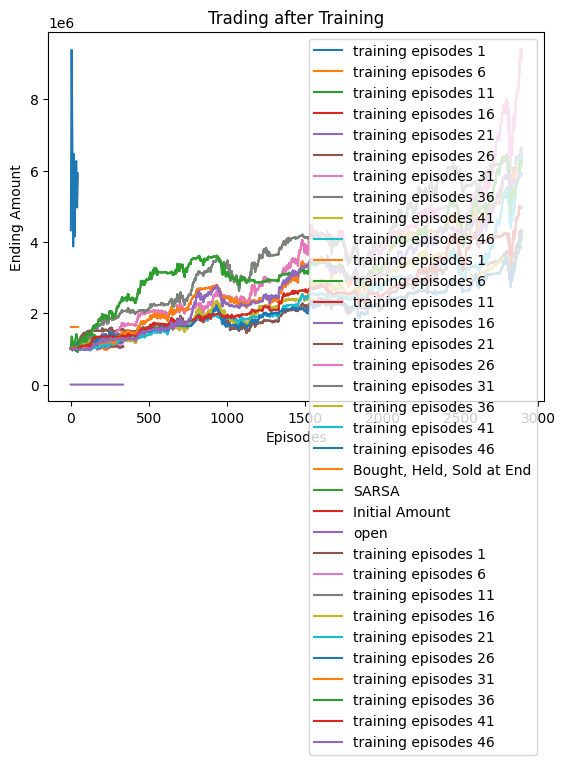

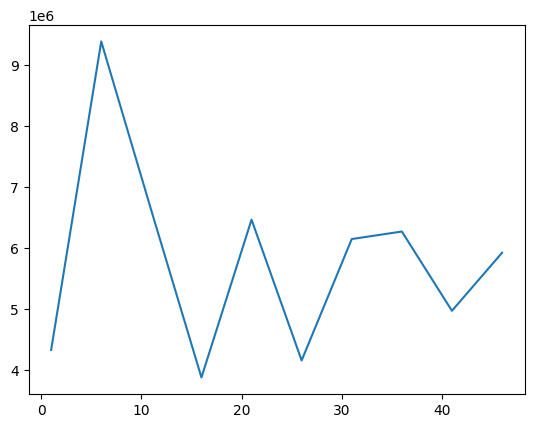

In [16]:
import matplotlib.pyplot as plt

%matplotlib inline
for e, x in zip(episodes_for_training, end_of_training_assets):
    plt.plot(list(range(len(x))), x, label=f"training episodes {e}")
plt.legend()
plt.show()

final_amounts = [mem[-1] for mem in end_of_training_assets]
plt.plot(episodes_for_training, final_amounts)
plt.show()


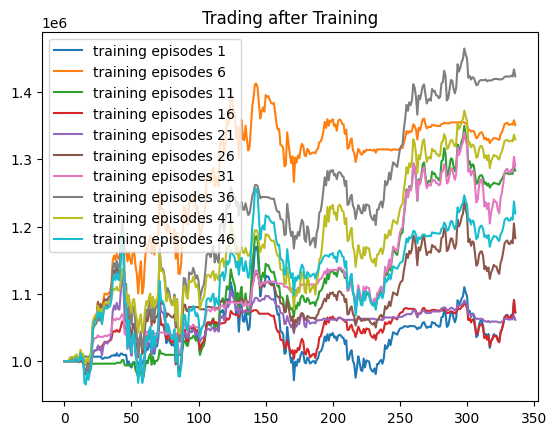

In [17]:
for e, x in zip(episodes_for_training, end_of_trading_assets):
    plt.plot(list(range(len(x))), x, label=f"training episodes {e}")
plt.legend()
plt.title('Trading after Training')
plt.show()

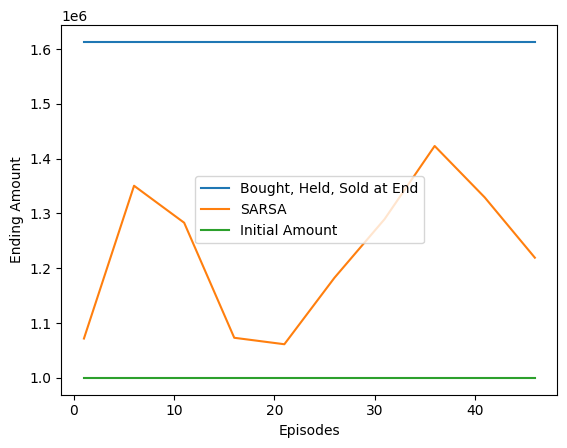

<Axes: >

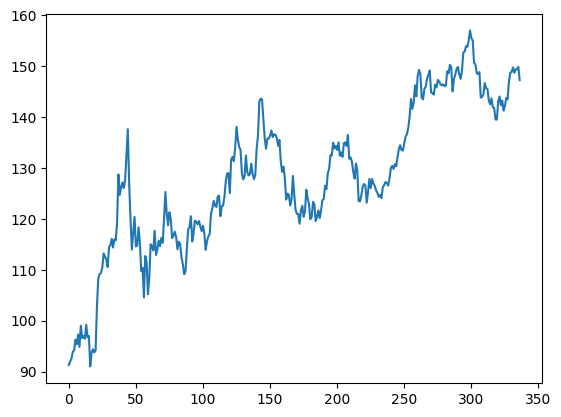

In [18]:
final_amounts = [mem[-1] for mem in end_of_trading_assets]

starting_value = trade[(trade['date'] == '2020-07-01') & (trade['tic'] == 'AAPL')]['open'].values[0]
stocks = 1_000_000 / starting_value

end_value =trade[(trade['date'] == '2021-10-29') & (trade['tic'] == 'AAPL')]['open'].values[0]
end_amount_if_bought_and_held = end_value * stocks

plt.plot(episodes_for_training, [end_amount_if_bought_and_held] * len(episodes_for_training), label='Bought, Held, Sold at End')
plt.plot(episodes_for_training, final_amounts, label='SARSA')
plt.plot(episodes_for_training, [1_000_000] * len(episodes_for_training), label='Initial Amount')
plt.xlabel('Episodes')
plt.ylabel('Ending Amount')
plt.legend()
plt.show()
trade[(trade['date'] >= '2020-07-01') & (trade['tic'] == 'AAPL')]['open'].plot()

In [19]:
len(Q.keys())

3092